In [1]:
# import openai

In [218]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt
import tsensor
import logging
logging.getLogger("matplotlib.font_mangaer").setLevel(logging.ERROR)
logging.disable(logging.WARNING)

In [3]:
# openai.api_key = os.environ["OPENAI_API_KEY"]

In [4]:
# %reload_ext genai

In [5]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [6]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [7]:
!ls -l data

total 16656
-rw-r--r-- 1 pete-00 pete-00 17051982 May 14 07:18 mnist.pkl.gz


In [8]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [9]:
lst1 = list(x_train[0])

In [10]:
vals = lst1[200:210]

In [11]:
vals, len(lst1)

([0.0,
  0.0,
  0.0,
  0.19140625,
  0.9296875,
  0.98828125,
  0.98828125,
  0.98828125,
  0.98828125,
  0.98828125],
 784)

In [12]:
def chunks(x, sz):
    for i in range(0, len(x), sz):
        yield x[i:i+sz]

In [13]:
val_iter = chunks(vals, 5)

In [14]:
len(next(chunks(lst1, 28)))

28

In [15]:
mpl.rcParams['image.cmap'] = 'gray'

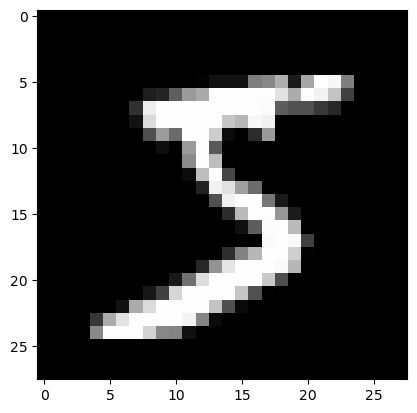

In [16]:
plt.imshow(list(chunks(lst1, 28)))

In [17]:
from itertools import islice

In [18]:
it = iter(lst1)
islice(it, 5)

In [19]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.0, 0.0]

In [20]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

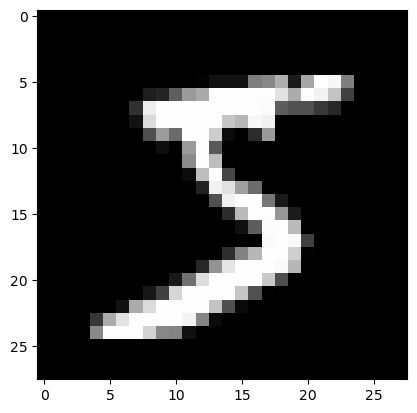

In [21]:
plt.imshow(img)

In [22]:
class Matrix:
    def __init__(self, xs):
        self.xs = xs
    def __getitem__(self, idxs):
        return self.xs[idxs[0]][idxs[1]]

In [23]:
m = Matrix(img)

In [24]:
m[20,15]

0.98828125

In [25]:
import torch
from torch import tensor

In [26]:
tensor([1,2,3])

tensor([1, 2, 3])

In [27]:
tens = tensor(img)

In [28]:
tens[20,15]

tensor(0.9883)

In [29]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [30]:
x_train.shape

torch.Size([50000, 784])

In [31]:
x_train.dtype

torch.float32

In [32]:
imgs = x_train.reshape(-1, 28, 28)
imgs.shape

torch.Size([50000, 28, 28])

In [33]:
imgs[0].shape

torch.Size([28, 28])

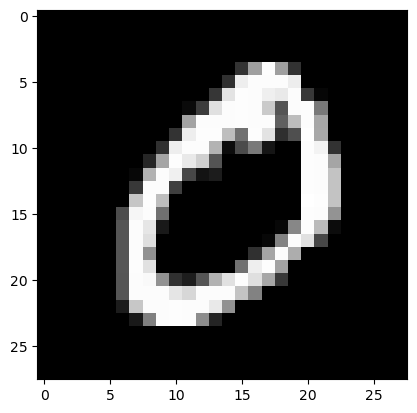

In [34]:
plt.imshow(imgs[1]);

In [35]:
n,c = x_train.shape

In [36]:
n, c

(50000, 784)

In [37]:
x_train.shape

torch.Size([50000, 784])

In [38]:
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [39]:
min(y_train), max(y_train)

(tensor(0), tensor(9))

In [40]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

### Random Number Generators

In [41]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [42]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [43]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [44]:
rand(), rand(), rand(),

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

In [45]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.9559050644103264
In child: 0.9559050644103264


In [46]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.5751])
In child: tensor([0.5751])


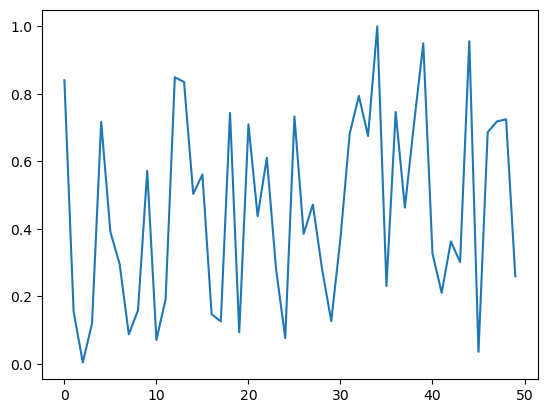

In [47]:
plt.plot([rand() for _ in range(50)]);

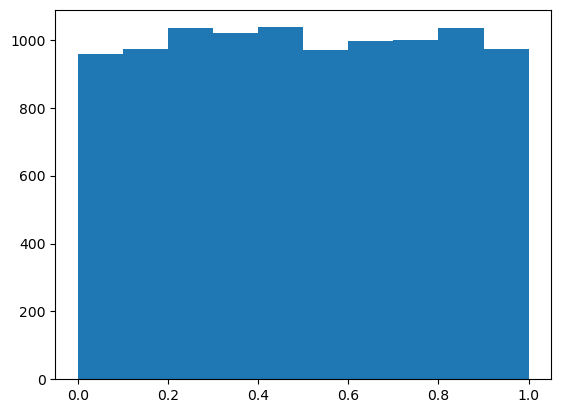

In [48]:
plt.hist([rand() for _ in range(10000)]);

In [49]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

2.04 ms ± 96.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 4.56 times longer than the fastest. This could mean that an intermediate result is being cached.
41.9 µs ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Matrix Multiplication

- Set manual seed
- Initialize weights for shape 784 x 10
- Initialize bias of zeros of shape 10

In [51]:
torch.manual_seed(4)

In [52]:
w = torch.randn(784, 10)
w.shape

torch.Size([784, 10])

In [53]:
b = torch.zeros(10)
b

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

- Create Matrix 1 consisting of the x validation set 
- Create Matrix 2 consisting of the weights

In [54]:
m1 = x_train[:5]

In [55]:
m2 = w

In [56]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

- Deconstruction the shape of each to 2 variables each, one for rows and one for columns

In [57]:
ar, ac = m1.shape
br, bc = m2.shape
(ar, ac), (br, bc)

((5, 784), (784, 10))

- Create a tensor of zeros, `t1`, with the dimensions Matrix 1 rows, Matrix 2 columns

In [58]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

- Create a loop that will get the dot product of Matrix 1 and Matrix 2 and store the results in `t1`

In [59]:
for i in range(ar):
    for j in range(bc):
        for k in range(ac):
            t1[i,j] += m1[i,k] * m2[k,j]

In [60]:
t1.shape

torch.Size([5, 10])

- Turn the loop into a callable function that takes 2 inputs representing the matrices

In [61]:
def matrix_mult(m1, m2):
    ar, ac = m1.shape
    br, bc = m2.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += m1[i,k] * m2[k,j]
    return c

- Time the Matrix multiplication loop

In [62]:
%time _ = matrix_mult(m1,m2)

CPU times: user 351 ms, sys: 0 ns, total: 351 ms
Wall time: 351 ms


### Numba

- import njit from numba

In [63]:
from numba import njit

- create a function that multiplies all the elements in 2 matrices and returns the sum, recreating the multiplication operation from the `matrix_mult` function

In [64]:
@njit
def dot(a, b):
    total = 0.
    for i in range(len(a)): 
        total += a[i] * b[i]
    return total

- Try with and without njit using numpy arrays

In [65]:
from numpy import array

dot(array([2.,4,5,6]), array([5.,4,6,8]))- Time both types of operations

In [66]:
dot(array([2.,4,5,6]), array([5.,4,6,8]))

104.0

In [67]:
%time dot(array([2.,4,5,6]), array([5.,4,6,8]))

CPU times: user 22 µs, sys: 4 µs, total: 26 µs
Wall time: 27.7 µs


104.0

In [68]:
%time dot(array([2.,4,5,6]), array([5.,4,6,8]))

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 28.6 µs


104.0

- update `matrix_mult` to use the `dot` created above(using njit)

In [69]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [70]:
def matmul(m1, m2):
    ar, ac = m1.shape
    br, bc = m2.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):       #5
        for j in range(bc):   #784
            c[i,j] = dot(m1[i,:], m2[:,j])
    return c

- assign `m1` and `m2` as variables as numpy arrays 

In [71]:
m1a, m2a = m1.numpy(), m2.numpy()

- Use `test_close` on `t1` and `matmul`, imported from fastcore

In [72]:
from fastcore.test import *

In [73]:
test_close(t1, matmul(m1a, m2a))

- Time matmul

In [74]:
%timeit -n 50 matmul(m1a,m2a)

196 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Elementwise Ops

- Create 2 Rank 1 tensors

In [75]:
a = tensor([1.,200,30,4,500,6])
b = tensor([10.,22,44,55,66,33])
a, b, len(a) == len(b)

(tensor([  1., 200.,  30.,   4., 500.,   6.]),
 tensor([10., 22., 44., 55., 66., 33.]),
 True)

- Add them

In [76]:
a + b

tensor([ 11., 222.,  74.,  59., 566.,  39.])

- Compare them > or < for boolean values

In [77]:
a > b

tensor([False,  True, False, False,  True, False])

- Get a percentage of true/false values

In [78]:
(a > b).float().mean()

tensor(0.3333)

- Create a new rank 2 tensor

In [79]:
m = tensor([[1.,2,3], [4,5,6], [7,8,9]])
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste. This is the source LaTeX that I pasted to render the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

- Recreate the operation above on the `m` tensor created earlier

In [80]:
sf = (m*m).sum()
sf

tensor(285.)

In [81]:
sf.sqrt()

tensor(16.8819)

- Check the different ways to index select the rows and columns of `m`

In [82]:
m[2], m[2, :]

(tensor([7., 8., 9.]), tensor([7., 8., 9.]))

In [83]:
m[:, 2], m[:, 2]

(tensor([3., 6., 9.]), tensor([3., 6., 9.]))

- Update the matrix multiplication function to use elementwise operations instead of the `dot` function

In [84]:
def matmul(m1, m2):
    ar, ac = m1.shape
    br, bc = m2.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):       #5
        for j in range(bc):   #784
            c[i,j] = (m1[i,:] * m2[:,j]).sum()
    return c

- Check that we're getting the same result using `test_close`

In [85]:
test_close(t1, matmul(m1,m2))

- Use timeit to on 50 iterations to try the new function on `m1` and `m2`

In [86]:
%timeit -n 50 _=matmul(m1,m2)

475 µs ± 9.29 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


- Redefine `matmul` using `torch.dot` for the dot product and test its time

### Broadcasting

In [102]:
a = tensor([10,20,-50.])

- Use broadcasting to check *>0* with a scalar

In [103]:
a > 0

tensor([ True,  True, False])

- Normalize the dataset by subtracting the mean from the entire dataset and dividing by the standard deviation

In [105]:
a.std()

tensor(37.8594)

In [104]:
(a - a.mean()) / a.std()

tensor([ 0.4402,  0.7044, -1.1446])

In [ ]:
mean = torch.mean(a)
variance = torch.mean(torch.square(a - mean))
std = torch.sqrt(variance)

print("Standard deviation of a:", std)


Standard Deviation

$$\sigma_a = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(a_i - \mu_a)^2}$$

where $\mu_a$ is the mean of tensor `a` and $n$ is the number of elements in `a`.


In [119]:
def std_dev(x):
    mean = torch.mean(x)
    variance = torch.mean(torch.square(x - mean))
    std = torch.sqrt(variance)

    print("Standard deviation:", std)

In [108]:
b = tensor([1,2,3,4,5.])

In [123]:
b.std()

tensor(1.5811)

In [126]:
b.std(unbiased=True), b.std(unbiased=False)

(tensor(1.5811), tensor(1.4142))

In [132]:
numpy_b = b.detach().numpy()

In [135]:
numpy_b.std(), numpy_b.std(ddof=1)

(1.4142135, 1.5811388)

In [115]:
b.std(), b.mean(), tensor(2.).sqrt()

(tensor(1.5811), tensor(3.), tensor(1.4142))

<b>Torch uses Bessel's Correction for a sample by default, Numpy uses formula for population - to disable in torch, set `unbiased=False`, to enable sample correction in Numpy, set delta degrees of freedom `ddof=1`

- Add 1 using broadcasting to `a`

In [136]:
a + 1

tensor([ 11.,  21., -49.])

- Multiply rank-2 matrix by a scalar

In [137]:
a * 4

tensor([  40.,   80., -200.])

In [142]:
b = tensor([[10,20,30],[40., 50, 60.], [70,80,90]])

In [143]:
b

tensor([[10., 20., 30.],
        [40., 50., 60.],
        [70., 80., 90.]])

- Expand a new tensor to match above

In [146]:
c = a.expand_as(b)
c

tensor([[ 10.,  20., -50.],
        [ 10.,  20., -50.],
        [ 10.,  20., -50.]])

- Check storage

In [152]:
c.storage()

 10.0
 20.0
 -50.0
[torch.storage._TypedStorage(dtype=torch.float32, device=cpu) of size 3]

- Check stride

In [153]:
c.stride()

(0, 1)

## Matmul with broadcasting

- Get the length of `m1`

In [155]:
len(m1), m1.shape

(5, torch.Size([5, 784]))

- Reshape `m1` to be the correct image size 28x28

In [156]:
m1[0].reshape(28,28).shape

torch.Size([28, 28])

- use `plt` to show the image

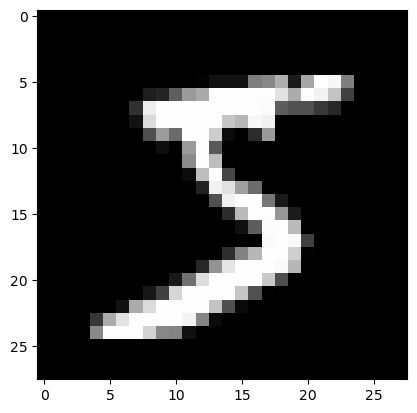

In [157]:
plt.imshow(m1[0].reshape(28,28))

- assign the image to `digit`

In [159]:
digit = m1[0]

In [160]:
digit.shape, m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [162]:
digit[:,None].expand_as(m2).shape

torch.Size([784, 10])

Update the `matmul` function to use broadcasting

In [163]:
# old matmul for ref
def matmul(m1, m2):
    ar, ac = m1.shape
    br, bc = m2.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):       #5
        for j in range(bc):   #784
            c[i,j] = (m1[i,:] * m2[:,j]).sum()
    return c

In [173]:
m1[1,:,None] * m2, (m1[1,:,None] * m2).shape

(tensor([[-0., 0., -0.,  ..., 0., -0., -0.],
         [0., 0., -0.,  ..., -0., 0., -0.],
         [0., -0., 0.,  ..., -0., -0., 0.],
         ...,
         [0., -0., 0.,  ..., -0., 0., 0.],
         [-0., -0., 0.,  ..., 0., 0., -0.],
         [0., 0., 0.,  ..., -0., -0., 0.]]),
 torch.Size([784, 10]))

In [203]:
m1.shape, m1[1].shape, m1[1,:].shape

(torch.Size([5, 784]), torch.Size([784]), torch.Size([784]))

In [ ]:
tsensor

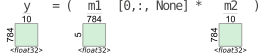

In [220]:
with tsensor.explain():
     y = (m1[0,:, None] * m2)

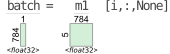

In [223]:
with tsensor.explain():
    for i in range(5):
        batch = m1[i,:,None]
        

In [234]:
m2[:,0].shape

torch.Size([784])

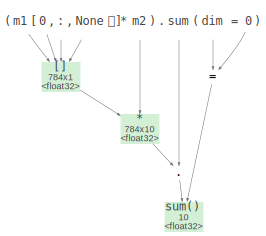

In [230]:
tsensor.astviz("(m1[0,:, None] * m2).sum(dim=0)")

In [211]:
m1[i,:, None] * m2

tensor([[-0., 0., -0.,  ..., 0., -0., -0.],
        [0., 0., -0.,  ..., -0., 0., -0.],
        [0., -0., 0.,  ..., -0., -0., 0.],
        ...,
        [0., -0., 0.,  ..., -0., 0., 0.],
        [-0., -0., 0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., -0., -0., 0.]])

In [190]:
matmul(m1, m2).shape

A Rows: 5
C Shape: torch.Size([5, 10])


torch.Size([5, 10])

In [251]:
def matmul(m1, m2):
    (ar, ac), (br, bc) = m1.shape, m2.shape
    c = torch.zeros(ar, bc)
    # print(f"A Rows: {ar}")
    # print(f"C Shape: {c.shape}")
    for i in range(ar):
        c[i] = (m1[i,:, None] * m2).sum(dim=0)
        # print(f"row {i}")
        # with tsensor.explain():
        #     c[i] = (m1[i,:, None] * m2).sum(dim=0)            
    return c

In [252]:
test_close(t1, matmul(m1, m2))

In [253]:
%timeit -n 50 _=matmul(m1, m2)

68 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [257]:
tr = matmul(x_train, w)

In [258]:
%time _=matmul(x_train, w)

CPU times: user 1.46 s, sys: 12.9 ms, total: 1.47 s
Wall time: 623 ms


## Einstein Summation

In [260]:
w.shape, m1.shape, m2.shape

(torch.Size([784, 10]), torch.Size([5, 784]), torch.Size([784, 10]))

In [261]:
mr = torch.einsum('ik,kj->ikj',m1,m2)

In [263]:
mr.shape

torch.Size([5, 784, 10])

In [268]:
mr.sum(1)

tensor([[ 15.0770,   5.9219,  -9.3105, -16.6213,   3.7590, -13.5234,  -0.8179,
           6.0461,  -5.9127,   4.0996],
        [ 12.1238,   8.1639,  -7.9339,  11.0765,   3.4699, -16.0789,   6.0388,
           6.3092,  10.5815,  -4.0340],
        [  2.9155,   4.7364,   0.0837,  -6.0591,   8.1037,   0.5639,  -1.8486,
          -1.7989,   9.6132,   3.0633],
        [ 10.6312,   2.8186,  -2.6437,   2.4454,  13.8741,   0.8767,  -1.7191,
           2.5493,  -4.4823,  -1.8833],
        [  3.1404,   3.3872, -12.6444,  -7.1171,  -9.1252,   2.7898,  -0.0796,
          -1.8457,   7.5512,   2.1222]])

In [271]:
ein_m1 = torch.randn(1, 4, 64, 64)
ein_m2 = torch.randn(1, 4, 64, 64)

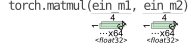

In [279]:
with tsensor.explain():
    torch.matmul(ein_m1, ein_m2)

In [288]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [283]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [289]:
torch.einsum('ik, kj -> ij', m1, m2)

tensor([[ 15.08,   5.92,  -9.31, -16.62,   3.76, -13.52,  -0.82,   6.05,  -5.91,   4.10],
        [ 12.12,   8.16,  -7.93,  11.08,   3.47, -16.08,   6.04,   6.31,  10.58,  -4.03],
        [  2.92,   4.74,   0.08,  -6.06,   8.10,   0.56,  -1.85,  -1.80,   9.61,   3.06],
        [ 10.63,   2.82,  -2.64,   2.45,  13.87,   0.88,  -1.72,   2.55,  -4.48,  -1.88],
        [  3.14,   3.39, -12.64,  -7.12,  -9.13,   2.79,  -0.08,  -1.85,   7.55,   2.12]])

In [285]:
ein_m1.shape, ein_m2.shape

(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

In [292]:
torch.matmul(ein_m1, ein_m2)

tensor([[[[-13.39,  16.86,  -6.32,  ...,  -4.42,  24.00,   3.94],
          [  0.82, -13.95,  -9.62,  ...,   5.42,  -1.51,  -1.75],
          [  6.56,   8.27,  14.86,  ..., -16.24,   8.32,   5.11],
          ...,
          [-14.37,  -3.85,   7.11,  ...,   6.46,  10.83,   8.93],
          [ -9.28, -18.29, -13.65,  ...,  -4.85,  11.68,  16.51],
          [ -4.25,  -4.25,  10.32,  ...,   0.03,   3.27,   6.17]],

         [[  8.03,   8.37,   0.21,  ...,  19.56, -13.51,   0.44],
          [ -4.09,  -1.39,   4.86,  ...,   0.89,   6.33,   5.26],
          [ 11.68, -10.85,  -4.13,  ...,  12.79, -10.65,  -3.31],
          ...,
          [  6.35,  -4.50,   6.53,  ...,  -5.34, -12.00,  -9.22],
          [  8.73, -14.41,  -1.03,  ...,  -2.55,  -0.69,  11.17],
          [ 15.73,  11.47,   3.66,  ...,   0.77,   4.93,   2.62]],

         [[ -5.97,  -9.37,  -1.12,  ..., -12.97,   3.10,  -0.34],
          [ -1.10,  -0.72,   2.53,  ...,   3.19,   8.59, -17.17],
          [  1.82,   7.65,   1.86,  ...,  

In [300]:
torch.einsum('ijlk, ijkm -> ijlm', ein_m1, ein_m2)

tensor([[[[-13.39,  16.86,  -6.32,  ...,  -4.42,  24.00,   3.94],
          [  0.82, -13.95,  -9.62,  ...,   5.42,  -1.51,  -1.75],
          [  6.56,   8.27,  14.86,  ..., -16.24,   8.32,   5.11],
          ...,
          [-14.37,  -3.85,   7.11,  ...,   6.46,  10.83,   8.93],
          [ -9.28, -18.29, -13.65,  ...,  -4.85,  11.68,  16.51],
          [ -4.25,  -4.25,  10.32,  ...,   0.03,   3.27,   6.17]],

         [[  8.03,   8.37,   0.21,  ...,  19.56, -13.51,   0.44],
          [ -4.09,  -1.39,   4.86,  ...,   0.89,   6.33,   5.26],
          [ 11.68, -10.85,  -4.13,  ...,  12.79, -10.65,  -3.31],
          ...,
          [  6.35,  -4.50,   6.53,  ...,  -5.34, -12.00,  -9.22],
          [  8.73, -14.41,  -1.03,  ...,  -2.55,  -0.69,  11.17],
          [ 15.73,  11.47,   3.66,  ...,   0.77,   4.93,   2.62]],

         [[ -5.97,  -9.37,  -1.12,  ..., -12.97,   3.10,  -0.34],
          [ -1.10,  -0.72,   2.53,  ...,   3.19,   8.59, -17.17],
          [  1.82,   7.65,   1.86,  ...,  

In [302]:
torch.einsum('ijkl, ijmk -> ijml', ein_m1, ein_m2)

tensor([[[[     6.81,     -6.37,    -10.67,  ...,     13.49,    -13.03,      2.34],
          [   -10.73,     -6.23,      5.82,  ...,      9.38,     -2.87,      9.16],
          [     5.24,     -3.21,     15.01,  ...,    -10.06,     -5.68,     11.22],
          ...,
          [   -12.64,      5.45,     -7.52,  ...,     -1.28,      8.01,      0.02],
          [   -15.25,      6.30,      6.14,  ...,     -6.42,      4.56,     -0.59],
          [     7.61,      0.81,      0.73,  ...,      8.35,      2.12,     -3.00]],

         [[     0.73,      8.17,     14.53,  ...,     20.64,      4.10,     -5.03],
          [     1.99,     -0.01,      4.35,  ...,      3.19,     -3.00,     11.38],
          [     5.17,      6.93,     12.96,  ...,     -0.39,      7.71,      1.15],
          ...,
          [    -1.19,     -6.61,      6.63,  ...,      9.98,     -1.08,      3.98],
          [     4.03,      5.77,      7.26,  ...,    -12.62,      7.52,     -2.70],
          [     7.23,      9.59,      2.13, 